# Finding a simple ML strategy to outperfom DCA on the Nasdaq 100 (NDX)

This notebook outlines a simple strategy attempting to outperform dollar-cost-averaging (DCA) on the Nasdaq 100 index (NDX). The process is broken down into the following steps:
1. Estimate the "fair value" of the index using a logarithmic regression;
2. Put together a risk metric that uses several indicators, including the "fair value", to estimate the level of risk associated with buying into the market; 
3. Train a simple ML classifier that attempts to outperform a monthly DCA strategy on the index.

We manage to get a meager ~3% outperformance on the DCA strategy. This could easily be improved by adding additional features and adapting our ML-powered investing strategy.

In [1]:
import json
import pandas as pd
import numpy as np
import math
import sklearn
import matplotlib.pyplot as plt

## Data loading
We load the monthly price points from yahoo finance

In [2]:
#json data of monthly Nasdaq-100 price data - source https://finance.yahoo.com/quote/%5ENDX/history/?frequency=1mo&period1=497021400&period2=1730309471
with open('data.json', 'r') as f:
    data = json.loads(f.read())
    
df = pd.DataFrame({
    'timestamp' : data['chart']['result'][0]['timestamp'],
    'price': data['chart']['result'][0]['indicators']['quote'][0]['close']
})
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.head(5)

,timestamp,price,datetime
0,496987200,115.480003,1985-10-01 04:00:00
1,499669200,126.059998,1985-11-01 05:00:00
2,502261200,132.294998,1985-12-01 05:00:00
3,504939600,132.925003,1986-01-01 05:00:00
4,507618000,140.425003,1986-02-01 05:00:00


<AxesSubplot: xlabel='datetime'>

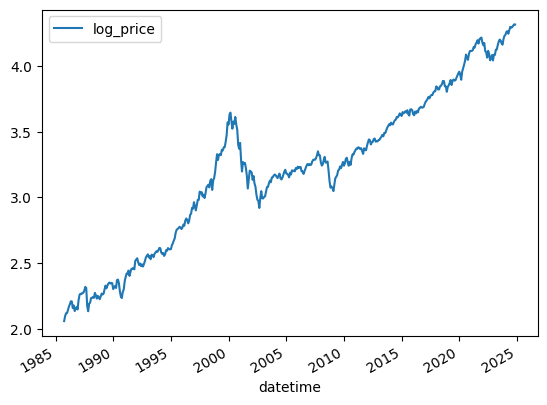

In [3]:
#Convert prices to log10
df['log_price'] = df.price.apply(lambda x : math.log(x,10.0))
df.plot(x='datetime', y = 'log_price')

# Finding the "fair value" of the index using a regression

We perform 2 types of fitting: 
* The first one takes all data points
* The second one excludes the bubble points from the internet mania that provides a slightly different fit.

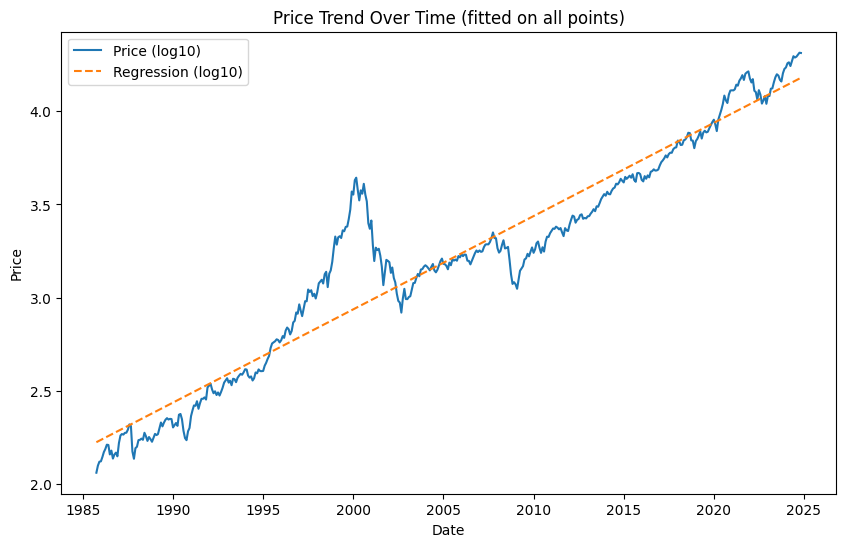

In [4]:
from sklearn.linear_model import LinearRegression

#data fitted to all points
X_all = df[['timestamp']]
y_all = df['log_price']

model = LinearRegression()
model.fit(X_all, y_all)

df['log_price_trend'] = model.predict(X_all)
df['price_trend'] = df.log_price_trend.apply(lambda x: 10**x)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['log_price'], label='Price (log10)')
plt.plot(df['datetime'], df['log_price_trend'], label='Regression (log10)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Trend Over Time (fitted on all points)')
plt.legend()
plt.show()

We can also fit our data excluding the Internet mania of '98 - '00

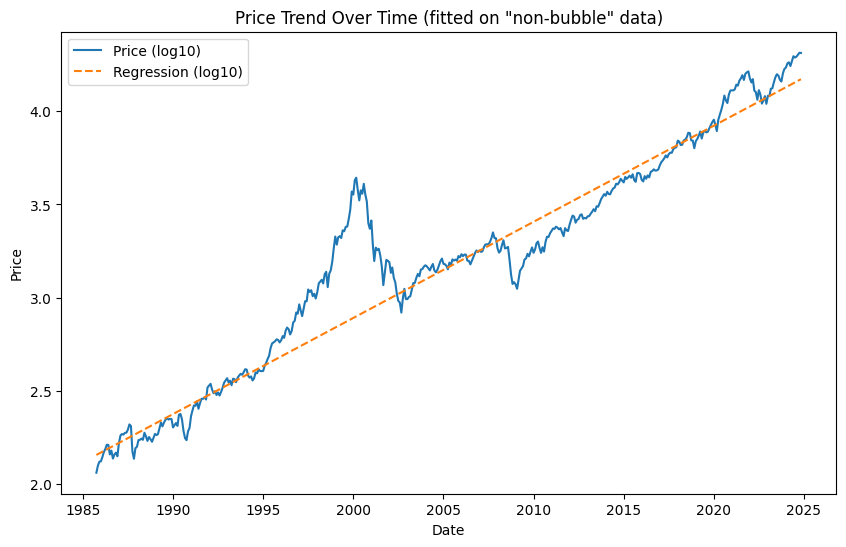

In [5]:
#Exclude bubble data from the internet bubble
X = df[(df.timestamp < 900000000) | (df.timestamp > 1000000000)][['timestamp']]
y = df[(df.timestamp < 900000000) | (df.timestamp > 1000000000)]['log_price']

model = LinearRegression()
model.fit(X, y)

df['log_price_trend'] = model.predict(X_all)
df['price_trend'] = df.log_price_trend.apply(lambda x: 10**x)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['log_price'], label='Price (log10)')
plt.plot(df['datetime'], df['log_price_trend'], label='Regression (log10)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Trend Over Time (fitted on "non-bubble" data)')
plt.legend()
plt.show()

# Determining an index risk score
## Gap to "fair value"

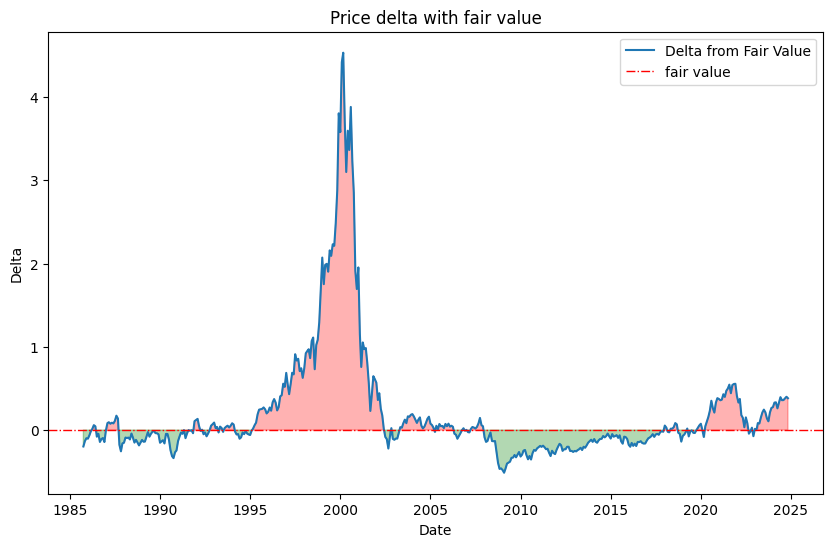

In [6]:
df['fair_value_delta'] = df.price/df.price_trend - 1#).apply(lambda x: math.log(x, 10.0))#df.log_price/df.log_price_trend - 1

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['fair_value_delta'], label='Delta from Fair Value')
plt.axhline(y=0, color='red', linestyle='-.', linewidth=1, label='fair value')
plt.fill_between(df['datetime'], df['fair_value_delta'], 0, where=(df['fair_value_delta'] > 0), color='red', alpha=0.3, )
plt.fill_between(df['datetime'], df['fair_value_delta'], 0, where=(df['fair_value_delta'] < 0), color='green', alpha=0.3, )
plt.xlabel('Date')
plt.ylabel('Delta')
plt.title('Price delta with fair value')
plt.legend()
plt.show()

In [7]:
import time

print(
    'Current Nasdaq 100 fair value:', 10**model.predict(
        pd.DataFrame([[time.time()]], columns = ['timestamp'])
    )[0]
)

Current Nasdaq 100 fair value: 14850.864374558832


## Delta to shorter and longer moving averages
We choose to measure the delta to the 6 month, 12 month and 48 month Moving Average

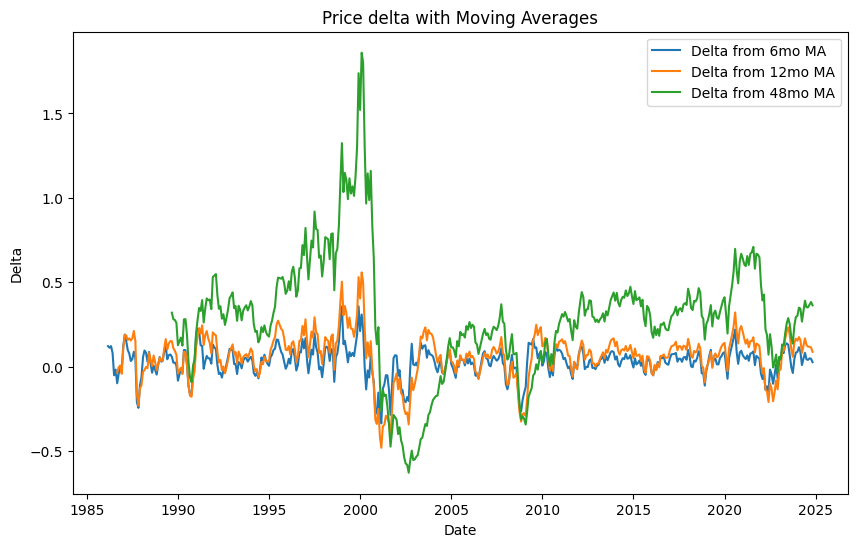

In [8]:
#add MAs and MA delta
plt.figure(figsize=(10, 6))
for window in [6,12,48]:
    df[str(window)+'_ma'] = df['price'].rolling(window=window).mean()
    df[str(window)+'_ma_delta'] = df.price / df[str(window)+'_ma'] - 1
    plt.plot(df['datetime'], df[str(window)+'_ma_delta'], label=f'Delta from {window}mo MA')

plt.xlabel('Date')
plt.ylabel('Delta')
plt.title('Price delta with Moving Averages')
plt.legend()
plt.show()

## RSI

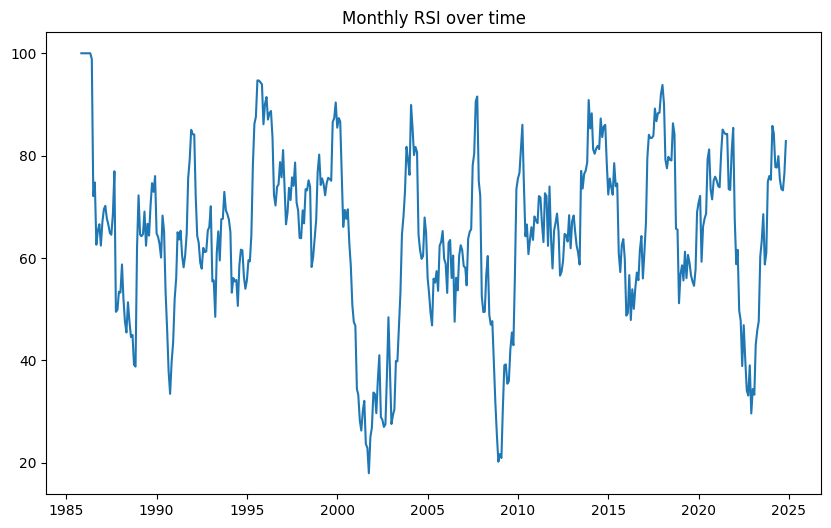

In [9]:
def rsi(df, column = 'price', window = 14):
    df_copy = df[[column]].copy()
    
    # Calculate daily price changes
    df_copy['change'] = df_copy[column].diff()

    # Calculate gains and losses
    df_copy['gain'] = df_copy['change'].where(df_copy['change'] > 0, 0)
    df_copy['loss'] = -df_copy['change'].where(df_copy['change'] < 0, 0)

    # Calculate the average gain and loss
    df_copy['avg_gain'] = df_copy['gain'].rolling(window=window, min_periods=1).mean()
    df_copy['avg_loss'] = df_copy['loss'].rolling(window=window, min_periods=1).mean()

    # Calculate the Relative Strength (RS)
    df_copy['rs'] = df_copy['avg_gain'] / df_copy['avg_loss']

    # Calculate RSI
    df_copy['rsi'] = 100 - (100 / (1 + df_copy['rs']))
    
    return df_copy['rsi']

df['rsi'] = rsi(df)

plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df.rsi, label=f'RSI')
plt.title('Monthly RSI over time')
plt.show()

## Derive a simple Risk metric `EZ Risk score`
After scaling our 5 metrics, we can sum them up to create a simple risk metric that oscillates between 0 and 1 to estimate the amount of froth in the market. We see that this metric does a decent job at identifying lower risk entries vs tops

In [10]:
from sklearn.preprocessing import MinMaxScaler

features = ['6_ma_delta', '12_ma_delta', '48_ma_delta', 'fair_value_delta', 'rsi']
data = df[features]
scaler = MinMaxScaler()
scaler.fit(data)
df['ez_risk_score'] = scaler.transform(data).sum(axis=1)
df['ez_risk_score_normalized'] = (df['ez_risk_score'] - df['ez_risk_score'].min()) / (df['ez_risk_score'].max() - df['ez_risk_score'].min())

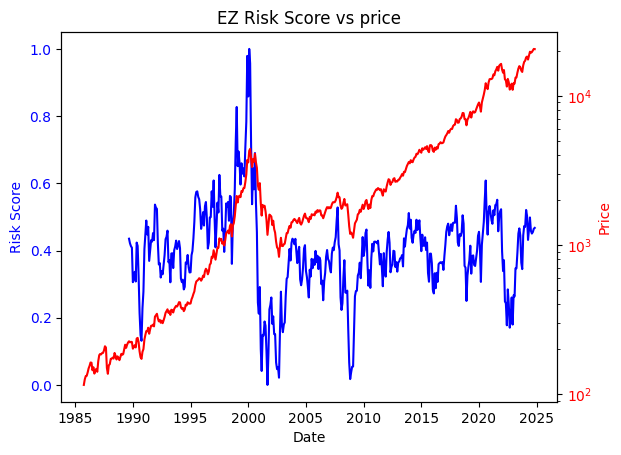

In [11]:
fig, ax1 = plt.subplots()

# Plot the first line on the primary y-axis
ax1.plot(df.datetime, df.ez_risk_score_normalized, color='b', label='Risk Score (normalized)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Risk Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis and plot the second line
ax2 = ax1.twinx()
ax2.plot(df.datetime, df.price, color='r', label='Exp(x/3)')
ax2.set_ylabel('Price', color='r')
ax2.set_yscale('log')  # Set log scale on the secondary y-axis
ax2.tick_params(axis='y', labelcolor='r')

# Add a title and show the plot
plt.title('EZ Risk Score vs price')
plt.show()

## Future price ML prediction

We use our metrics to create a simple ML model that predicts where the price will be in the next X months. We assign the following values: 
* 0 if the future price is lower;
* 1 if the future price is higher.

The idea is having a model that tells us if it's better to invest in the NDX or in X-month duration T-bills. If the index is predicted to be lower in X months, then we'd rather invest in X-mo T-Bills; if the index is predicted to be higher, then we invest in the NDX.

**Important note: There's obvious data leakage by using a delta to the fair value that is fit to all data points. This would need to be adapted by recalculating the fair value regression for each point in time.**

The "Benchmark accuracy" represents the base accuracy you would get by always predicting `1` (future price higher = always invest in the NDX)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

np.random.seed(100)

#define the target as 1=price is higher in X months, 0=price is lower in X months
TARGET_OUTLOOK_MONTHS = 18 #1.5 years
df['target'] = (df.price.shift(-TARGET_OUTLOOK_MONTHS) - df.price).apply(lambda x: 0 if x <=0 else 1)

df_eval = df.dropna().reset_index(drop=True).copy()

X = df_eval[features]
y = df_eval['target']

print(f'Benchmark accuracy: {y.sum()/y.count()}')

Benchmark accuracy: 0.8463356973995272


In [13]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state = 100)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Accuracy: {acc}\nPrecision: {precision}\nRecall: {recall}')

df_eval['prediction'] = model.predict_proba(X)[:, 1]

Accuracy: 0.9433962264150944
Precision: 0.9574468085106383
Recall: 0.9782608695652174


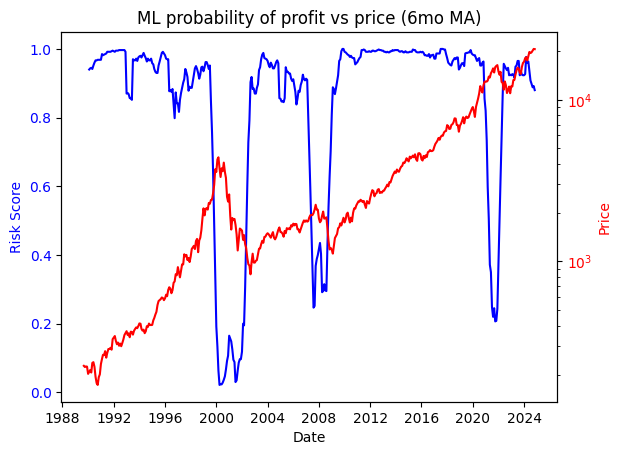

In [14]:
fig, ax1 = plt.subplots()

PREDICTION_MA_LENGTH = 6
df_eval['prediction_moving_average'] = df_eval.prediction.rolling(PREDICTION_MA_LENGTH).mean()

# Plot the first line on the primary y-axis
#ax1.plot(df_eval.datetime, df_eval.prediction, color='b', label='Risk Score (normalized)')
ax1.plot(df_eval.datetime, df_eval.prediction_moving_average, color='b', label=f'Risk Score (normalized) {PREDICTION_MA_LENGTH}MA')

ax1.set_xlabel('Date')
ax1.set_ylabel('Risk Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis and plot the second line
ax2 = ax1.twinx()
ax2.plot(df_eval.datetime, df_eval.price, color='r', label='Exp(x/3)')
ax2.set_ylabel('Price', color='r')
ax2.set_yscale('log')  # Set log scale on the secondary y-axis
ax2.tick_params(axis='y', labelcolor='r')

# Add a title and show the plot
plt.title(f'ML probability of profit vs price ({PREDICTION_MA_LENGTH}mo MA)')
plt.show()

## We simulate a simple strategy where we ask our algo to tell us whether we should invest into Nasdaq100 or T-bills

We use the predicted "probability of future profit" which is the `predict_proba` output of our trained classifier. We multiply our monthly investment by this probability to get the amount we allocate to buying the NDX, the remaining amount (1 - probability) is allocated to T-bills. The money in t-bills is locked for the entire duration and becomes available again at maturity. 

In [16]:
#simulate DCA
current_nasdaq100_price = int(df_eval.price.tail(1))
usd_per_month = 100
df_eval['cash'] = 0
#df_eval['additional_investment'] = 0
df_eval['investment_usd'] = 0
df_eval['investment'] = 0
df_eval['dca_monthly_invest'] = usd_per_month / df_eval['price']

print(f'DCA:\n - Total invested: {len(df_eval)*usd_per_month}\n - Value at the end: {df_eval["dca_monthly_invest"].sum()*current_nasdaq100_price}\n - PNL: {df_eval["dca_monthly_invest"].sum()*current_nasdaq100_price/(len(df_eval)*usd_per_month) - 1}')

prediction_kpi = 'prediction'#_moving_average'
IDLE_CASH_RETURN_PERCENT = 2 #2%/yr avg return on cash

#tracking the amount available when t-bills mature
tbill_maturity_cash = {}

for i, r in df_eval.copy().iterrows():

    probability_of_future_profit = np.nan_to_num(r[prediction_kpi], nan = 1)

    available_cash = usd_per_month + (tbill_maturity_cash[i] if i in tbill_maturity_cash else 0)

    ndx_invest = probability_of_future_profit * available_cash
    bills_invest = available_cash * (1 - probability_of_future_profit)

    tbill_maturity_cash[i+TARGET_OUTLOOK_MONTHS] = bills_invest * (1+IDLE_CASH_RETURN_PERCENT/100)**(TARGET_OUTLOOK_MONTHS/12)

    df_eval.loc[i, 'investment_usd'] = ndx_invest

df_eval['investment'] = df_eval['investment_usd'] / df_eval['price']
print(f'ML Strategy:\n - Total invested: {df_eval.investment_usd.sum()}\n - Value at the end: {df_eval.investment.sum()*current_nasdaq100_price}\n - PNL: {df_eval.investment.sum()*current_nasdaq100_price/df_eval.investment_usd.sum() - 1}')

DCA:
 - Total invested: 42300
 - Value at the end: 826071.0858316581
 - PNL: 18.528867277344162
ML Strategy:
 - Total invested: 42401.99678233685
 - Value at the end: 851331.61042858
 - PNL: 19.077630183284533
